In [27]:
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms.functional import pil_to_tensor
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import time
plt.style.use('classic')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
IMG_SIZE = (128,128)

In [29]:
annotations = pd.read_csv("data/faces.csv")
annotations.iloc[0]

image_name    00001722.jpg
width                 1333
height                2000
x0                     490
y0                     320
x1                     687
y1                     664
Name: 0, dtype: object

## Centerness

Centerness is is sort of a weighting in this case. We will get our final pred by multiplying the class_score with centerness

It is the sqrt(min(l,r)/max(l,r)*min(t,b)/max(t,b)), basically the ratio of the max and min distance horizontally and vertically from the sides. The bigger the number the closer the point is to the center. This helps with the 

In [30]:
def generate_centerness_map(bbxs, feature_map_size):
    centerness_map = np.zeros(feature_map_size)
    for bbox in bbxs:
        xmin, ymin, xmax, ymax = bbox
        
        # Coord grid
        y_grid, x_grid = np.meshgrid(np.arange(feature_map_size[0]), np.arange(feature_map_size[1]), indexing='ij')

        l = x_grid - xmin  # Dist to the left
        r = xmax - x_grid  # Dist to the right
        t = y_grid - ymin  # Dist to the top
        b = ymax - y_grid  # Dist to the bottom 

        # only pos nums
        l = np.clip(l, 0, None)
        r = np.clip(r, 0, None)
        t = np.clip(t, 0, None)
        b = np.clip(b, 0, None)

        # Calculate centerness score
        centerness = np.sqrt((np.minimum(l, r) / np.maximum(l, r)) * (np.minimum(t, b) / np.maximum(t, b)))
        
        # Replace NaNs with zeros
        centerness = np.nan_to_num(centerness)
        centerness_map = np.maximum(centerness_map, centerness)
    
    return torch.tensor(centerness_map).view(1,128,128)

In [31]:
def generate_class_map(bbxs,feature_map_size):
    class_map = np.zeros((feature_map_size[0],feature_map_size[1]))
    for bbox in bbxs:
        xmin, ymin, xmax, ymax = np.array(bbox).astype(int)
        class_map[ymin:ymax,xmin:xmax]=1
    return torch.tensor(class_map).view(1,128,128)

In [32]:
def generate_bbox_map(bbxs,feature_map_size):
    img_size = np.array(feature_map_size)
    bbox_maps = np.full((4,img_size[0],img_size[1]),feature_map_size[0])
    y_grid, x_grid = np.meshgrid(np.arange(feature_map_size[0]),np.arange(feature_map_size[1]), indexing='ij')

    for i,bbox in enumerate(bbxs):
        xmin, ymin, xmax, ymax = np.array(bbox).astype(int)
        l = x_grid - xmin
        r = xmax - x_grid
        t = y_grid - ymin
        b = ymax - y_grid
        if i < 1:
            bbox_maps[0][ymin:ymax,xmin:xmax] = l[ymin:ymax,xmin:xmax]
            bbox_maps[1][ymin:ymax,xmin:xmax] = r[ymin:ymax,xmin:xmax]
            bbox_maps[2][ymin:ymax,xmin:xmax] = t[ymin:ymax,xmin:xmax]
            bbox_maps[3][ymin:ymax,xmin:xmax] = b[ymin:ymax,xmin:xmax]
        else:
            l[l<0] = 2**31 - 1
            r[r<0] = 2**31 - 1
            t[t<0] = 2**31 - 1
            b[b<0] = 2**31 - 1
            bbox_maps[0][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[0],l)[ymin:ymax,xmin:xmax]
            bbox_maps[1][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[1],r)[ymin:ymax,xmin:xmax]
            bbox_maps[2][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[2],t)[ymin:ymax,xmin:xmax]
            bbox_maps[3][ymin:ymax,xmin:xmax] = np.minimum(bbox_maps[3],b)[ymin:ymax,xmin:xmax]
    bbox_maps[bbox_maps==feature_map_size[0]]=0
    bbox_maps = bbox_maps/feature_map_size[0]
    return torch.tensor(bbox_maps)

In [33]:
class FacesDataset(Dataset):
    
    def __init__(self,image_df,img_shape = (256,256)):
        super().__init__()
        self.img_dataframe = image_df
        self.img_tgt_shape = img_shape
        self.image_resize_transform = transforms.Resize(img_shape)

    def __len__(self):
        return self.img_dataframe.shape[0]
    
    def get_img(self,index):
        face_bbox = []
        path = 'data/images/' + annotations.iloc[index]['image_name']
        img = pil_to_tensor(Image.open(path))
        x_scale, y_scale = img.shape[2]/self.img_tgt_shape[1], img.shape[1]/self.img_tgt_shape[0] 
        img = self.image_resize_transform(img)
        query_df = annotations[(self.img_dataframe.image_name == self.img_dataframe.iloc[index]['image_name'] )].copy()
        for index,row in query_df.iterrows():
            face_bbox.append([row['x0']// x_scale, row['y0']// y_scale, row['x1']// x_scale, row['y1']// y_scale])
        return img,face_bbox
    
    def __getitem__(self, index):
        img,face_bbox = self.get_img(index)
        img = img.permute(1,2,0)
        centerness_map=generate_centerness_map(face_bbox,img.shape[:2])
        class_map=generate_class_map(face_bbox,img.shape[:2])
        bbox_maps=generate_bbox_map(face_bbox,img.shape[:2])
        label = torch.cat((centerness_map,class_map,bbox_maps),dim=0)
        img = img.permute(2,0,1)
        return img.float(),label
    
    def plot_img(self,idx):
        img, bboxes = self.get_img(idx)
        img = img.permute(1,2,0)
        # Display the image
        plt.imshow(img)

        # Get the current reference
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Create a Rectangle patch
        for bbox in bboxes:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

        plt.show()

In [34]:
ds = FacesDataset(annotations,IMG_SIZE)
faces_dataloader = DataLoader(ds,batch_size=8,shuffle=True)

## Function to load the image and all of its labels

In [194]:
def plot_img_and_labels(idx):
    img,bbxs = ds.__getitem__(idx)
    img = img.permute(1,2,0).int()
    centerness_map = bbxs[:1].permute(1,2,0)
    class_map = bbxs[1:3]
    bbox_maps = bbxs[3:]
    fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(12, 8),layout="compressed")
    fig.set_facecolor("w")
    for ax in axs.reshape(-1):
        ax.set_xticks([])
        ax.set_yticks([])
    axs[0,0].title.set_text("Original image")
    axs[0,0].imshow(img)
    axs[0,1].title.set_text("Centerness map")
    axs[0,1].imshow(centerness_map)
    axs[1,0].title.set_text("Class map")
    axs[1,0].imshow(class_map[0])
    axs[1,1].title.set_text("Bounding box map (left)")
    axs[1,1].imshow(bbox_maps[0])

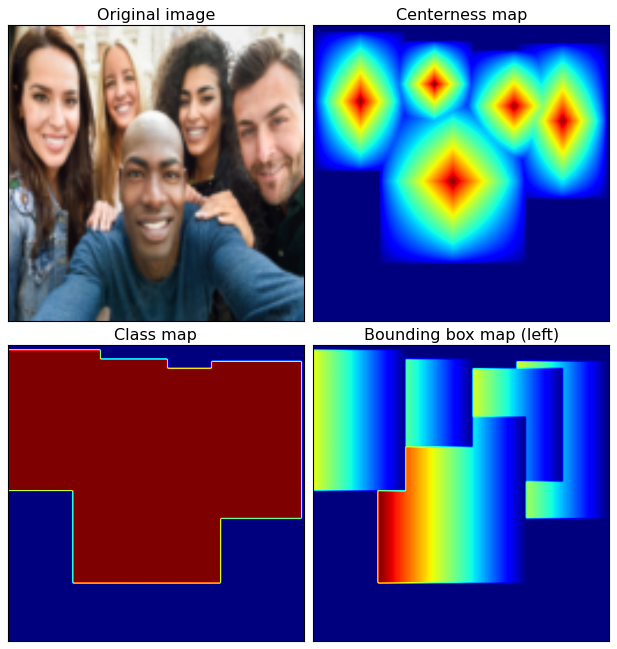

In [195]:
plot_img_and_labels(120)

## FCOS-like architecture

This consists of a feature pyramid network which will forward its output to three different heads 
-   a class head to determine the probability of a pixel belonging to a certain class
-   a bounding box head which determines the bounding box coordinates for a predicted class
-   a centerness head to predict how close a pixel is to the center of that 

In [35]:
class FCOS_NN(nn.Module):
    def __init__(self,num_of_fpn_layers,num_of_classes, num_of_starting_channels = 32, num_of_ending_channels = 128):
        super().__init__()
        self.conv1 = nn.Conv2d(3,num_of_starting_channels,kernel_size=3,padding=1)
        self.fpn = nn.ModuleList()
        self.refine_conv = nn.ModuleList()
        self.upscale = nn.ModuleList()
        input_channels = num_of_starting_channels
        output_channels = num_of_starting_channels*2
        factor = 2
        for _ in range(num_of_fpn_layers):
            self.fpn.append(nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            ))
            self.refine_conv.append(nn.Sequential(
                nn.Conv2d(output_channels,num_of_ending_channels,kernel_size=1,padding=0),
                nn.BatchNorm2d(num_of_ending_channels),
                nn.ReLU()
            ))
            self.upscale.append(
                nn.Upsample(scale_factor=factor,mode='bilinear')
            )
            factor = factor*2
            input_channels = output_channels
            output_channels = output_channels*2
        self.cls_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,num_of_classes,kernel_size=3,padding=1)
        )
        self.bbox_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,4,kernel_size=3,padding=1)
        )
        self.centerness_head = nn.Sequential(
            nn.Conv2d(num_of_ending_channels,num_of_ending_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(num_of_ending_channels),
            nn.Conv2d(num_of_ending_channels,1,kernel_size=3,padding=1)
        )
        

    def forward(self,x):
        feature_layers = []
        x = self.conv1(x)
        for layer in self.fpn:
            x = layer(x)
            feature_layers.append(x)
        for i, (feature,layer) in enumerate(zip(feature_layers,self.refine_conv)):
            feature_layers[i] = layer(feature)
        for i, (feature,layer) in enumerate(zip(feature_layers,self.upscale)):
            feature_layers[i] = layer(feature)
        x = feature_layers[0]
        for i in range(len(feature_layers)-1):
            x = x + feature_layers[i+1]
        cls_pred = self.cls_head(x)
        centerness_pred = self.centerness_head(x)
        bbox_pred = self.bbox_head(x)
        cls_pred = torch.nn.functional.sigmoid(cls_pred)
        centerness_pred = torch.nn.functional.sigmoid(centerness_pred)
        bbox_pred = torch.nn.functional.sigmoid(bbox_pred)
        return torch.cat((centerness_pred,cls_pred,bbox_pred),dim=1)

### Check if it outputs the correct shape

In [36]:
model = FCOS_NN(num_of_fpn_layers = 4,num_of_classes = 1,num_of_ending_channels=256).to(device)
X = torch.rand((1,3,128,128)).to(device)
out = model(X)
out.shape

torch.Size([1, 6, 128, 128])

# Training Loop

Parameters:
-   epoch
-   loss functions
-   optimizer

In [39]:
model = model.to(device)
epochs = 8
optim = torch.optim.AdamW(model.parameters())
bce_loss_fn = torch.nn.BCELoss()
bbox_loss_fn = torch.nn.SmoothL1Loss()
for i in range(epochs):
    bbox_running_loss = 0.
    bce_running_loss = 0.
    last_loss = 0.
    for i,(X,y) in enumerate(tqdm(faces_dataloader)):
        optim.zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        bbox_preds = pred[:,2:,:].permute(0,2,3,1).float()
        left_pred, right_pred, top_pred,  bottom_pred = pred[:, 2, :, :], pred[:, 3, :, :], pred[:, 4, :, :], pred[:, 5, :, :]
        left_true, right_true, top_true,  bottom_true = y[:, 2, :, :], y[:, 3, :, :], y[:, 4, :, :], y[:, 5, :, :]
        left_loss = bbox_loss_fn(left_pred, left_true).mean()
        right_loss = bbox_loss_fn(top_pred, top_true).mean()
        top_loss = bbox_loss_fn(right_pred, right_true).mean()
        bottom_loss = bbox_loss_fn(bottom_pred, bottom_true).mean()
        centerness_bce_loss = bce_loss_fn(pred[:,0,:].float(),y[:,0,:].float()).mean()
        class_bce_loss = bce_loss_fn(pred[:,1,:].float(),y[:,1,:].float()).mean()
        loss = centerness_bce_loss + class_bce_loss + left_loss +right_loss + top_loss + bottom_loss
        loss.backward()
        bbox_running_loss += left_loss.item() +right_loss.item() + top_loss.item() + bottom_loss.item()
        bce_running_loss += centerness_bce_loss.item() + class_bce_loss.item()
        optim.step()
        if i % 100 == 99:
            bbox_last_loss = bbox_running_loss / 100 # loss per batch
            bce_last_loss = bce_running_loss / 100 # loss per batch
            print('  batch {} regression loss: {} , bce_loss: {}'.format(i + 1, bbox_last_loss,bce_last_loss ))
            bbox_running_loss = 0.
            bce_running_loss = 0.

 24%|██▍       | 101/419 [00:17<00:51,  6.12it/s]

  batch 100 regression loss: 0.20318679486775745 , bce_loss: 0.9687511864304542


 48%|████▊     | 201/419 [00:34<00:35,  6.13it/s]

  batch 200 regression loss: 0.016131730857813636 , bce_loss: 0.5369926726818085


 72%|███████▏  | 301/419 [00:52<00:20,  5.88it/s]

  batch 300 regression loss: 0.01731247076465448 , bce_loss: 0.49678602762520313


 96%|█████████▌| 401/419 [01:11<00:03,  5.94it/s]

  batch 400 regression loss: 0.016053402310937378 , bce_loss: 0.4663369219750166


 24%|██▍       | 101/419 [00:18<00:51,  6.16it/s]

  batch 100 regression loss: 0.01590429862542564 , bce_loss: 0.4478985945880413


 48%|████▊     | 200/419 [00:35<00:37,  5.78it/s]

  batch 200 regression loss: 0.016208024561110316 , bce_loss: 0.4538529743254185


 72%|███████▏  | 300/419 [00:52<00:18,  6.28it/s]

  batch 300 regression loss: 0.012954025959271658 , bce_loss: 0.40461546652019026


 96%|█████████▌| 401/419 [01:11<00:03,  5.62it/s]

  batch 400 regression loss: 0.016211129083934954 , bce_loss: 0.42325472109019757


 24%|██▍       | 101/419 [00:17<00:52,  6.01it/s]

  batch 100 regression loss: 0.015638504649001975 , bce_loss: 0.3982024437189102


 48%|████▊     | 201/419 [00:35<00:35,  6.18it/s]

  batch 200 regression loss: 0.014311897420222945 , bce_loss: 0.38608674097806217


 72%|███████▏  | 301/419 [00:53<00:20,  5.75it/s]

  batch 300 regression loss: 0.012519145986222512 , bce_loss: 0.35377713218331336


 96%|█████████▌| 401/419 [01:10<00:02,  6.25it/s]

  batch 400 regression loss: 0.014433870352553209 , bce_loss: 0.3852601938694715


 24%|██▍       | 101/419 [00:17<00:59,  5.38it/s]

  batch 100 regression loss: 0.01399524261237299 , bce_loss: 0.35532902970910074


 48%|████▊     | 200/419 [00:34<00:35,  6.16it/s]

  batch 200 regression loss: 0.014926447767690042 , bce_loss: 0.3682813251763582


 72%|███████▏  | 301/419 [00:52<00:19,  6.02it/s]

  batch 300 regression loss: 0.012944050441692938 , bce_loss: 0.3431470412760973


 95%|█████████▌| 400/419 [01:10<00:03,  5.77it/s]

  batch 400 regression loss: 0.011065930610465879 , bce_loss: 0.3099235390126705


 24%|██▍       | 101/419 [00:17<00:52,  6.05it/s]

  batch 100 regression loss: 0.013193974248750602 , bce_loss: 0.322720292955637


 48%|████▊     | 201/419 [00:35<00:36,  6.02it/s]

  batch 200 regression loss: 0.01246123349587415 , bce_loss: 0.3189388681948185


 72%|███████▏  | 300/419 [00:53<00:30,  3.93it/s]

  batch 300 regression loss: 0.012982103463945717 , bce_loss: 0.31002928044646977


 95%|█████████▌| 400/419 [01:11<00:03,  6.09it/s]

  batch 400 regression loss: 0.01138442971663721 , bce_loss: 0.2973303934186697


 24%|██▍       | 101/419 [00:19<01:00,  5.28it/s]

  batch 100 regression loss: 0.011760978501639041 , bce_loss: 0.2936621981114149


 48%|████▊     | 201/419 [00:37<00:38,  5.67it/s]

  batch 200 regression loss: 0.0124219540553634 , bce_loss: 0.28162623271346093


 72%|███████▏  | 301/419 [00:55<00:18,  6.47it/s]

  batch 300 regression loss: 0.010180090357705684 , bce_loss: 0.2671550548821688


 96%|█████████▌| 401/419 [01:13<00:03,  5.95it/s]

  batch 400 regression loss: 0.012187159629279829 , bce_loss: 0.28965956408530474


 24%|██▍       | 100/419 [00:18<00:57,  5.58it/s]

  batch 100 regression loss: 0.008863258695293464 , bce_loss: 0.24241819988936186


 48%|████▊     | 201/419 [00:36<00:43,  5.01it/s]

  batch 200 regression loss: 0.013097889945519995 , bce_loss: 0.2731044147908688


 72%|███████▏  | 301/419 [00:54<00:19,  5.91it/s]

  batch 300 regression loss: 0.010160357234695699 , bce_loss: 0.2557587945461273


 95%|█████████▌| 400/419 [01:11<00:03,  5.62it/s]

  batch 400 regression loss: 0.011689952582193172 , bce_loss: 0.2700279674679041


 24%|██▍       | 101/419 [00:18<00:54,  5.82it/s]

  batch 100 regression loss: 0.009525274477693153 , bce_loss: 0.23359623342752456


 48%|████▊     | 201/419 [00:35<00:35,  6.13it/s]

  batch 200 regression loss: 0.011966808012005064 , bce_loss: 0.2602373069152236


 72%|███████▏  | 301/419 [00:52<00:18,  6.49it/s]

  batch 300 regression loss: 0.008442164281017496 , bce_loss: 0.22053647916764021


 96%|█████████▌| 401/419 [01:09<00:02,  6.12it/s]

  batch 400 regression loss: 0.010737152643313524 , bce_loss: 0.24957857564091682


100%|██████████| 419/419 [01:12<00:00,  5.77it/s]


## Finetune the bbox regression a bit more

In [84]:
epochs = 2
faces_dataloader = DataLoader(ds,batch_size=16,shuffle=True)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0001)
bce_loss_fn = torch.nn.BCELoss()
model.conv1.requires_grad_(False)
model.fpn.requires_grad_(False)
model.upscale.requires_grad_(False)
model.refine_conv.requires_grad_(False)
model.cls_head.requires_grad_(False)
model.centerness_head.requires_grad_(False)
bbox_loss_fn = torch.nn.SmoothL1Loss()
for i in range(epochs):
    for i,(X,y) in enumerate(tqdm(faces_dataloader)):
        optim.zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = 1.1*bbox_loss_fn(pred[:,0,:].float(),y[:,0,:].float()).mean()
        loss.backward()
        optim.step()

100%|██████████| 210/210 [00:29<00:00,  7.11it/s]


## Sanity check of the centerness output multiplied with the class probabilities

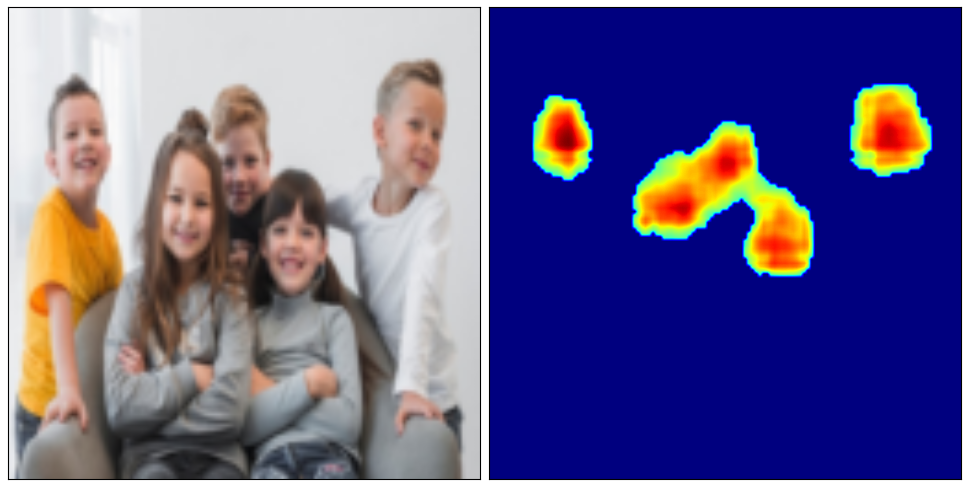

In [205]:
img = ds.get_img(5)[0].view(1,3,128,128).float().to(device)
out = model(img)
bboxes = out[:,2:].cpu().detach().numpy()
probability_map = out[0,0]*out[0,1]
probability_map[probability_map<0.4] = 0.
class_img = probability_map.cpu().detach().numpy()
img = ds.get_img(5)[0] 
fig, axs = plt.subplots(ncols=2,figsize=(12, 8),layout="compressed")
fig.set_facecolor("w")
for ax in axs.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
axs[1].imshow(class_img)
axs[0].imshow(img.permute(1,2,0).int())
plt.show()

## Do the same for bbox map

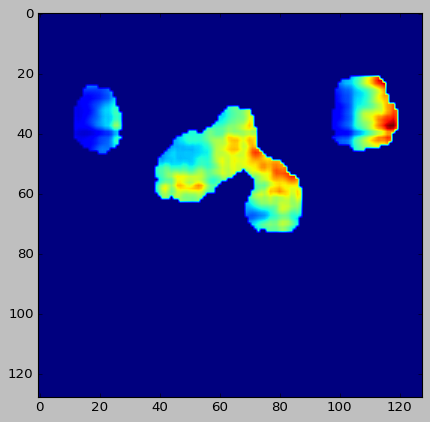

In [89]:
bboxes = out[:,2:].cpu().detach().numpy()
prob_map = probability_map.cpu()
bbox_xmin = bboxes[0,0]
bbox_xmin = np.where(prob_map > 0.2, bbox_xmin, 0)
plt.imshow(bbox_xmin)

## As it can be seen there will be lots of bbox suggestions made by the model and somehow these have to be "filtered" to get the best results: for this Non-Maximum Suppression (NMS) is used with Generalized Intersection over Union (GIoU) loss

In [77]:
def giou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])
    
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    x1_union = min(box1[0], box2[0])
    y1_union = min(box1[1], box2[1])
    x2_union = max(box1[2], box2[2])
    y2_union = max(box1[3], box2[3])
    union_area = (x2_union - x1_union) * (y2_union - y1_union)

    giou_value = inter_area / float(union_area) if union_area > 0 else 0.0
    if inter_area == 0:
        giou_value -= (union_area - inter_area) / float(union_area)

    return giou_value

def non_max_suppression(boxes, scores, threshold=0.5):
    """Perform Non-Maximum Suppression (NMS) on the bounding boxes."""
    if len(boxes) == 0:
        return []

    indices = np.argsort(scores)[::-1]
    selected_boxes = []

    while len(indices) > 0:
        current_idx = indices[0]
        selected_boxes.append(boxes[current_idx])

        remaining_boxes = boxes[indices[1:]]
        giou_values = np.array([giou(boxes[current_idx], box) for box in remaining_boxes])
        
        indices = indices[1:][giou_values < threshold]

    return np.array(selected_boxes)

In [206]:
def inference_on_img_by_idx(idx, threshold = 0.05):
    start_time = time.time()

    image_to_plot = ds.get_img(idx)[0]
    image_to_plot = image_to_plot.permute(1,2,0)
    image_to_plot = image_to_plot.numpy().reshape(128,128,3)
    img = ds.get_img(idx)[0].view(1, 3, 128, 128).float().to(device)
    out = model(img)

    bboxes = out[:, 2:].cpu().detach().numpy()
    probability_map = (out[0, 0] * out[0, 1])**2
    probability_map[probability_map < 0.4] = 0.

    valid_y, valid_x = np.nonzero(probability_map.cpu().detach().numpy())
    boxes = []
    scores = []

    for y, x in zip(valid_y, valid_x):
        d_t = bboxes[0, 0, y, x] * 128  
        d_b = bboxes[0, 1, y, x] * 128  
        d_l = bboxes[0, 2, y, x] * 128  
        d_r = bboxes[0, 3, y, x] * 128

        xmin = int(x - d_l)
        ymin = int(y - d_t)
        xmax = int(x + d_r)
        ymax = int(y + d_b)

        if xmax > xmin and ymax > ymin:
            boxes.append((xmin, ymin, xmax, ymax))
            scores.append(probability_map[y, x].item())

    boxes = np.array(boxes)
    scores = np.array(scores)

    final_boxes = non_max_suppression(boxes, scores, threshold)

    plt.imshow(image_to_plot)
    for box in final_boxes:
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        fill=False, edgecolor='red', linewidth=2))

    plt.title('Final Bounding Boxes After GIoU NMS')
    plt.axis('off')
    plt.show()

    # End the timer
    end_time = time.time()

    # Calculate the total time taken
    total_time = end_time - start_time
    print(f"Total time for detection: {total_time:.4f} seconds")

    # Output the final bounding boxes
    print("Final Bounding Boxes:", final_boxes)

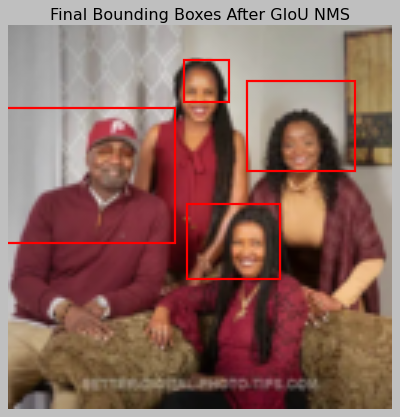

Total time for detection: 0.2627 seconds
Final Bounding Boxes: [[ 58  11  73  25]
 [ 79  18 115  48]
 [ -2  27  55  72]
 [ 59  59  90  84]]


In [207]:
inference_on_img_by_idx(230,threshold=0.05)